In [1]:
import os
import cPickle as pickle
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split

import sys
sys.path.append('../')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
from src.TTRegression import TTRegression
import urllib

In [2]:
def get_dummies(d, col):
    dd = pd.get_dummies(d.ix[:, col])
    dd.columns = [str(col) + "_%s" % c for c in dd.columns]
    return(dd)

In [3]:
# Reproducability.
np.random.seed(0)

dataset_path = 'car.data'
if (not os.path.isfile(dataset_path)):
    dataset_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
    print('Downloading data from %s' % dataset_url)
    urllib.urlretrieve(dataset_url, dataset_path)

print('... loading data')
car_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'target']
car_data = pd.read_csv(dataset_path, names=car_names, header=None)

print "dataset len: %d\n" % len(car_data)
print "Original targets:"
print car_data.target.value_counts()

# Make binary classification problem.
car_target = car_data['target']
car_target_binarized = (car_target.values != 'unacc') * 1

car_features = car_data.ix[:, :6]
car_features_one_hot = pd.concat([get_dummies(car_features, col) for col in list(car_features.columns.values)], axis = 1)
car_features_one_hot = car_features_one_hot.as_matrix()

# Shuffle.
idx_perm = np.random.permutation(len(car_data))

X, y = car_features_one_hot[idx_perm[:1500], :], car_target_binarized[idx_perm[:1500]]

... loading data
dataset len: 1728

Original targets:
unacc    1210
acc       384
good       69
vgood      65
Name: target, dtype: int64


# Train

In [7]:
plain_sgd = {}
riemannian_sgd = {}

for batch_size in [-1, 100, 500]:
    # To use the same order of looping through objects for all runs.
    np.random.seed(0)
    model = TTRegression('all-subsets', 'logistic', 4, 'sgd', max_iter=10000, verbose=1,
                         fit_intercept=False, batch_size=batch_size, reg=0.)
    model.fit(X, y)
    plain_sgd[batch_size] = model

    np.random.seed(0)
    # To use the same order of looping through objects for all runs.
    rieamannian_model = TTRegression('all-subsets', 'logistic', 4, 'riemannian-sgd', max_iter=800, verbose=1,
                                     batch_size=batch_size, fit_intercept=False, reg=0.)
    rieamannian_model.fit(X, y)
    riemannian_sgd[batch_size] = rieamannian_model

# Save

In [8]:
with open('riemannian_vs_baseline.pickle', 'wb') as f:
    obj = {'plain_sgd': plain_sgd, 'riemannian_sgd': riemannian_sgd, 'X': X, 'y': y}
    pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# Plot

In [9]:
params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [3, 2.5]
   }
mpl.rcParams.update(params)


colors = [(31, 119, 180), (44, 160, 44), (255, 127, 14), (255, 187, 120)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(colors)):
    r, g, b = colors[i]
    colors[i] = (r / 255., g / 255., b / 255.)

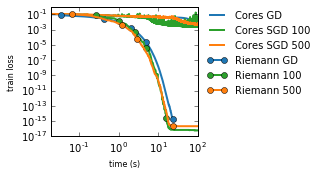

In [10]:
with open('riemannian_vs_baseline.pickle', 'rb') as f:
    logs = pickle.load(f)

fig = plt.figure()
plt.loglog(logs['plain_sgd'][-1].logger.time_hist,
           logs['plain_sgd'][-1].logger.loss_hist['train']['logistic'], label='Cores GD',
           linewidth=2, color=colors[0])
plt.loglog(logs['plain_sgd'][100].logger.time_hist, logs['plain_sgd'][100].logger.loss_hist['train']['logistic'],
           label='Cores SGD 100', linewidth=2, color=colors[1])
plt.loglog(logs['plain_sgd'][500].logger.time_hist, logs['plain_sgd'][500].logger.loss_hist['train']['logistic'],
           label='Cores SGD 500', linewidth=2, color=colors[2])

grid = np.array([0.01, 1, 5, 12, 60]) / 2.5
x = logs['riemannian_sgd'][-1].logger.time_hist
marker_indices = np.searchsorted(x, grid)
plt.loglog(logs['riemannian_sgd'][-1].logger.time_hist,
           logs['riemannian_sgd'][-1].logger.loss_hist['train']['logistic'],
           marker='o', markevery=marker_indices, label='Riemann GD', linewidth=2, color=colors[0])
grid = np.array([0.05, 2, 6, 12, 40]) / 2.5
x = logs['riemannian_sgd'][100].logger.time_hist
marker_indices = np.searchsorted(x, grid)
plt.loglog(logs['riemannian_sgd'][100].logger.time_hist,
           logs['riemannian_sgd'][100].logger.loss_hist['train']['logistic'],
           marker='o', markevery=marker_indices, label='Riemann 100', linewidth=2, color=colors[1])
grid = np.array([0.1, 3, 7.5, 60]) / 2.5
x = logs['riemannian_sgd'][500].logger.time_hist
marker_indices = np.searchsorted(x, grid)
plt.loglog(logs['riemannian_sgd'][500].logger.time_hist,
           logs['riemannian_sgd'][500].logger.loss_hist['train']['logistic'],
           marker='o', markevery=marker_indices, label='Riemann 500', linewidth=2, color=colors[2])

legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1.04), frameon=False)
plt.xlabel('time (s)')
plt.ylabel('train loss')
plt.minorticks_off()
ax = plt.gca()
ax.set_xlim([0.02, 100])
fig.tight_layout()